In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.2 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import inspect
import optuna

In [ ]:
data_type = 'float32' # sets the data type for calculations and such. Use tf.float64 for improved numerical stability or tf.float32 for improved memory usage and computational speed

tf.keras.utils.set_random_seed(42) # sets random seed for code reproducibility
tf.keras.backend.set_floatx(data_type)
tf.get_logger().setLevel('ERROR')

In [ ]:
def random_search(f, x, y, n_args, lb_list=[-10], up_list=[10], n_startup_trials=1000, **kwargs): # searches for the best starting point
    assert len(lb_list) == n_args == len(up_list)
    best_loss = np.Inf
    for i in range(n_startup_trials):
        test_beta = tf.cast(tf.concat([tf.random.uniform((1, 1), low, high) for (low, high) in zip(lb_list, up_list)], axis=0), dtype=data_type)
        loss = (tf.reduce_mean(tf.math.square(y - f(x, *test_beta)))).numpy() # mean squared error of solution
        if loss < best_loss:
            best_loss, beta_0 = loss, test_beta
    print(f'Starting point: {beta_0.numpy().tolist()}')
    return beta_0

In [ ]:
def optuna_search(f, x, y, n_args, lb_list=[-10], up_list=[10], n_trials=100, sampler=optuna.samplers.TPESampler(), verbose=False, **kwargs):
    def objective(trial):
        test_beta = tf.cast(tf.reshape([trial.suggest_float(f'{i}', low, high) for i, (low, high) in enumerate(zip(lb_list, up_list))], (-1, 1)), dtype=data_type)
        return (tf.reduce_mean(tf.math.square(y - f(x, *test_beta)))).numpy()

    assert len(lb_list) == n_args == len(up_list)
    if not verbose: optuna.logging.set_verbosity(optuna.logging.WARNING)
    else: optuna.logging.set_verbosity(optuna.logging.INFO)

    if __name__ == "__main__":
        study = optuna.create_study(direction='minimize', sampler=sampler)
        study.optimize(objective, n_trials=n_trials)

        trial = study.best_trial
        beta_0 = tf.cast(tf.reshape(list(trial.params.values()), (-1, 1)), dtype=data_type)

        print(f'Starting point: {beta_0.numpy().tolist()}')
        return beta_0

In [ ]:
def LMA_Regression(f, x, y,
                   _lambda_0=1.0, l_up=2, l_down=3, safety_lim=1E10,
                   max_iter=100, tol=1E-3, fletcher=False,
                   beta_0=None, search_algorithm=None, search_dict=None, **kwargs): # Levenberg-Marquadt-Fletcher Algorithm

    def get_tape(f, x, y, beta):
        with tf.GradientTape() as tape:
            f_x = f(x, *beta)
        residual = y - f_x
        loss = tf.reduce_mean(tf.square(residual)).numpy() # mean squared error of solution
        return f_x, residual, loss, tape

    x, y = tf.constant(x.copy(), dtype=data_type), tf.constant(y.copy(), dtype=data_type)
    x, y = tf.reshape(x, (-1,1)), tf.reshape(y, (-1,1)) # converts x, y to vertical vectors
    n_args = len(inspect.getfullargspec(f).args) - 1 # number of coefficients

    # initial guess
    if beta_0 is None:
        beta_0 = search_algorithm(f, x, y, n_args, **search_dict)
        beta = tf.Variable(beta_0)
    else:
        beta_0 = tf.cast(tf.reshape(tf.constant(beta_0), (-1, 1)), data_type)
        beta = tf.Variable(beta_0)

    # n_iter, initial damping factor
    i, _lambda = 0, _lambda_0
    # the algorithm
    f_x, residual, loss, tape = get_tape(f, x, y, beta)
    while i < max_iter and loss >= tol: # using a tf.function would certainly be faster, but for simpler applications using Eager Mode should suffice
        J = tf.squeeze(tape.jacobian(f_x, beta)) # jacobian matrix
        Jt = tf.transpose(J)
        Jt_J = Jt @ J

        while _lambda <= safety_lim: # checks whether or not lambda has diverged
            diag = tf.eye(n_args, dtype=data_type)
            if fletcher: diag *= tf.linalg.diag_part(Jt_J) # if fletcher == true, then the LMFA is computed
            delta = tf.linalg.inv(Jt_J + _lambda*diag) @ Jt @ residual # update step
            beta.assign_add(delta)

            # delayed gratification step, avoids extra Jacobian calculations
            f_x, new_residual, new_loss, tape = get_tape(f, x, y, beta)
            if new_loss >= loss: # rejects step and recalculates lambda
                _lambda *= l_up
                beta.assign_sub(delta)
            else: # accepts step and recalculates lambda
                _lambda /= l_down
                loss, residual = new_loss, new_residual
                i += 1
                break
        else: # true if _lambda > safety_lim
            print('Lambda diverged, returning current solution.')
            break

    print('Done.')
    return beta.numpy(), i, loss

In [ ]:
def sine(x, offset, amp, w, phi, **kwargs): return offset + amp*tf.math.sin(w*x + phi)

def exponential(x, a, b, **kwargs): return a*tf.math.exp(b*x)

def gaussian(x, mean, sd, **kwargs): return tf.math.exp(-((x - mean)/sd)**2/2)/(sd*np.sqrt(2*np.pi))

def double_gaussian(x, mean1, sd1, mean2, sd2, **kwargs): return gaussian(x, mean1, sd1) + gaussian(x, mean2, sd2)

In [ ]:
coeff1 = [2, -0.5]
coeff2 = [1.5, 1.5, 2, np.pi/2]
coeff3 = [-5, 3, 7, 2]

In [ ]:
x1 = np.linspace(-1, 10, 1000)
x2 = np.linspace(0, 4*np.pi, 1000)
x3 = np.linspace(-15, 15, 1000)

y1 = exponential(x1, *coeff1).numpy() + np.random.normal(0, .1, size=x1.shape[0])
y2 = sine(x2, *coeff2).numpy() + np.random.normal(0, .1, size=x2.shape[0])
y3 = double_gaussian(x3, *coeff3).numpy() + np.random.normal(0, .01, size=x3.shape[0])

## Exponential curve fitting

In [ ]:
random_search_dict1 = {'n_startup_trials': 1000,
                      'lb_list': [-10, -10],
                      'up_list': [10, 10],
}

optuna_search_dict1 = {'n_trials': 100,
                      'sampler': optuna.samplers.TPESampler(n_startup_trials=5, multivariate=False, seed=42),
                      'lb_list': [-10, -10],
                      'up_list': [10, 10],
                      'verbose': False,
}

lma_dict1 = {'f': exponential, # the function to be optimized, should be a callable
            'x': x1, # np.array, input vector
            'y': y1, # np.array, output vector
            '_lambda_0': 1.0, # initial damping factor
            'l_up': 2, # increment factor during delayed gratification step
            'l_down': 3, # decrement factor during delayed gratification step
            'max_iter': 100, # max iterations. also how many Jacobians will be calculated
            'tol': 2E-3, # mean squared error
            'fletcher': False, # execues the Levenberg-Marquardt-Fletcher Algorithm
            'safety_lim': 1E10, # if _lambda grows past this limit, the algorithm will halt execution
            'beta_0': None, # initial guess. if None the algorithm will execute a random search
            'search_algorithm': optuna_search, # search algorithm for random search
            'search_dict': optuna_search_dict1, # parameters for search algorithm in the form of **kwargs
}

In [ ]:
reg_coeff1, n_iter1, loss1 = LMA_Regression(**lma_dict1)

Starting point: [[2.6493732929229736], [-0.6504107713699341]]
Lambda diverged, returning current solution.
Done.


Coeff: [2, -0.5]
 Reg Coeff: [[1.9969749450683594], [-0.49662935733795166]]
 Iterations: 4
 Loss: 0.009569150395691395



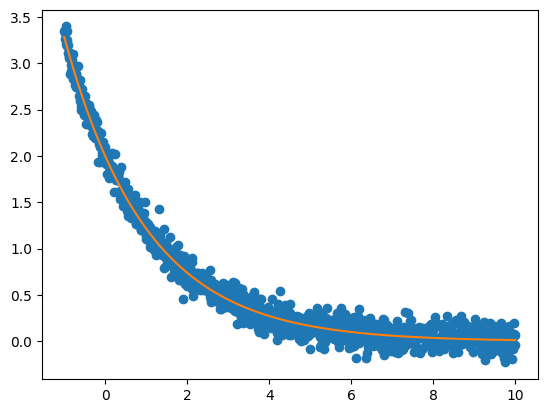

In [ ]:
print(f'Coeff: {coeff1}\n Reg Coeff: {reg_coeff1.tolist()}\n Iterations: {n_iter1}\n Loss: {loss1}\n')
plt.scatter(x1, y1)
plt.plot(x1, lma_dict1['f'](x1, *reg_coeff1), c='C1')
plt.show()

## Sinusoidal curve fitting

In [ ]:
random_search_dict2 = {'n_startup_trials': 1000,
                      'lb_list': [-10, -10, -10, -np.pi],
                      'up_list': [10, 10, 10, np.pi],
}

optuna_search_dict2 = {'n_trials': 100,
                      'sampler': optuna.samplers.TPESampler(n_startup_trials=5, multivariate=False, seed=42),
                      'lb_list': [-10, -10, -10, -np.pi],
                      'up_list': [10, 10, 10, np.pi],
                      'verbose': False,
}

lma_dict2 = {'f': sine, # the function to be optimized, should be a callable
            'x': x2, # np.array, input vector
            'y': y2, # np.array, output vector
            '_lambda_0': 1.0, # initial damping factor
            'l_up': 2, # increment factor during delayed gratification step
            'l_down': 3, # decrement factor during delayed gratification step
            'max_iter': 100, # max iterations. also how many Jacobians will be calculated
            'tol': 2E-3, # mean squared error
            'fletcher': True, # execues the Levenberg-Marquardt-Fletcher Algorithm
            'safety_lim': 1E10, # if _lambda grows past this limit, the algorithm will halt execution
            'beta_0': None, # initial guess. if None the algorithm will execute a random search
            'search_algorithm': optuna_search, # search algorithm for random search
            'search_dict': optuna_search_dict2, # parameters for search algorithm in the form of **kwargs
}

In [ ]:
reg_coeff2, n_iter2, loss2 = LMA_Regression(**lma_dict2)

Starting point: [[1.4359757900238037], [-0.3120529353618622], [2.4151530265808105], [2.0787878036499023]]
Lambda diverged, returning current solution.
Done.


Coeff: [1.5, 1.5, 2, 1.5707963267948966]
 Reg Coeff: [[1.5063353776931763], [-1.5024465322494507], [2.0009944438934326], [4.71264123916626]]
 Iterations: 7
 Loss: 0.009873815812170506
 Original Coeff Loss: 0.009989380919231107



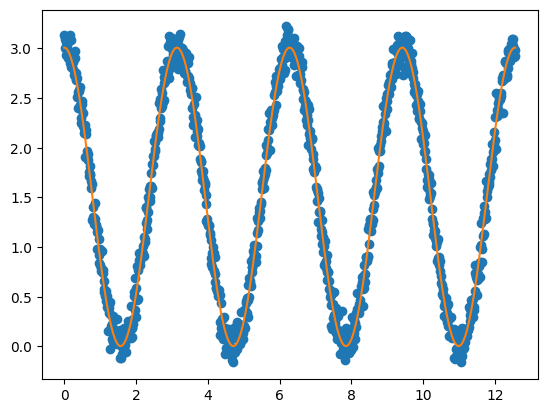

In [ ]:
print(f'Coeff: {coeff2}\n Reg Coeff: {reg_coeff2.tolist()}\n Iterations: {n_iter2}\n Loss: {loss2}\n Original Coeff Loss: {((y2 - sine(x2, *coeff2).numpy())**2).mean()}\n')
plt.scatter(x2, y2)
plt.plot(x2, lma_dict2['f'](x2, *reg_coeff2), c='C1')
plt.show()

## Double gaussian curve fitting

In [ ]:
random_search_dict3 = {'n_startup_trials': 1000,
                      'lb_list': [-10, -10, -10, -10],
                      'up_list': [10, 10, 10, 10],
}

optuna_search_dict3 = {'n_trials': 25,
                      'sampler': optuna.samplers.TPESampler(n_startup_trials=5, multivariate=False, seed=42),
                      'lb_list': [-10, -10, -10, -10],
                      'up_list': [10, 10, 10, 10],
                      'verbose': False,
}

lma_dict3 = {'f': double_gaussian, # the function to be optimized, should be a callable
            'x': x3, # np.array, input vector
            'y': y3, # np.array, output vector
            '_lambda_0': 1.0, # initial damping factor
            'l_up': 2, # increment factor during delayed gratification step
            'l_down': 3, # decrement factor during delayed gratification step
            'max_iter': 100, # max iterations. also how many Jacobians will be calculated
            'tol': 1E-4, # mean squared error
            'fletcher': True, # execues the Levenberg-Marquardt-Fletcher Algorithm
            'safety_lim': 1E10, # if _lambda grows past this limit, the algorithm will halt execution
            'beta_0': None, # initial guess. if None the algorithm will execute a random search
            'search_algorithm': optuna_search, # search algorithm for random search
            'search_dict': optuna_search_dict3, # parameters for search algorithm in the form of **kwargs
}

In [ ]:
reg_coeff3, n_iter3, loss3 = LMA_Regression(**lma_dict3)

Starting point: [[8.037298202514648], [6.38427209854126], [-3.0794951915740967], [7.478025436401367]]
Done.


Coeff: [-5, 3, 7, 2]
 Reg Coeff: [[7.052529335021973], [1.9859278202056885], [-5.037801265716553], [2.999174118041992]]
 Iterations: 4
 Loss: 9.949593368219212e-05
 Original Coeff Loss: 9.662491787544644e-05



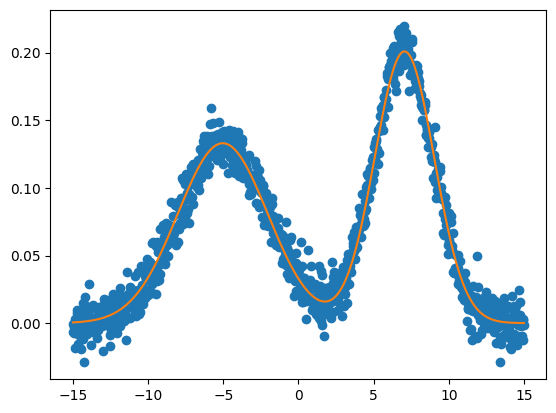

In [ ]:
print(f'Coeff: {coeff3}\n Reg Coeff: {reg_coeff3.tolist()}\n Iterations: {n_iter3}\n Loss: {loss3}\n Original Coeff Loss: {((y3 - double_gaussian(x3, *coeff3).numpy())**2).mean()}\n')
plt.scatter(x3, y3)
plt.plot(x3, lma_dict3['f'](x3, *reg_coeff3), c='C1')
plt.show()